In [1]:
import torch
import torchvision
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)

In [3]:
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)


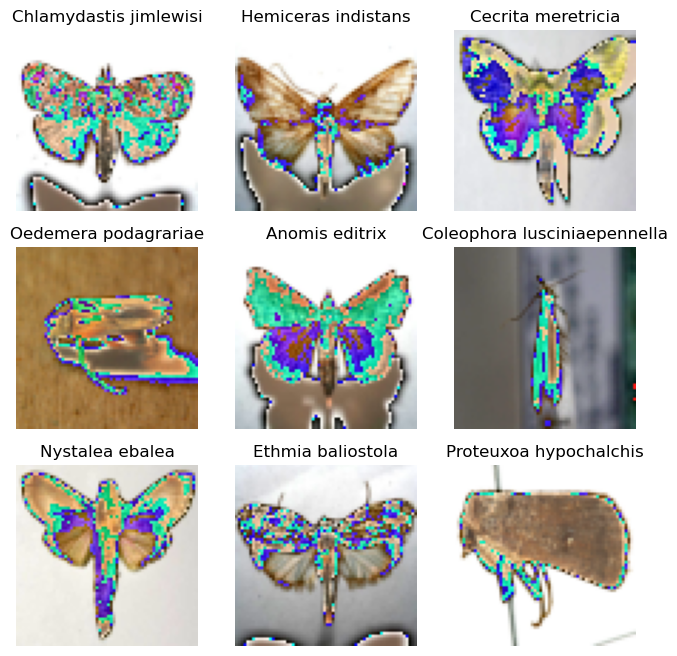

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_dataset), size=(1,)).item()
    img, label = image_dataset[sample_idx]
    img = transforms.functional.to_pil_image(img)
    figure.add_subplot(rows, cols, i)
    species_name = (list(image_dataset.class_to_idx.keys())[label]).replace('_',' ')
    plt.title(species_name)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [5]:
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

In [6]:
import random


nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.3)

train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)

In [7]:
from torch.utils.data import Dataset, DataLoader

class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
whole_dataset = WholeDataset(image_dataset)
#whole_dataset[0][0].shape
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

32424


32424

In [9]:
train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=True, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

print(len(train_imgs.indices))
print(len(val_imgs.indices))
print(len(test_imgs.indices))


10777
6734
14913


In [10]:
class Discriminator(torch.nn.Module):

    def __init__(self,n_feature_maps):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3,n_feature_maps,4,2,1,bias=False)
        self.relu1 = nn.LeakyReLU(0.2,inplace=True)
        self.conv2 = nn.Conv2d(n_feature_maps,2*n_feature_maps,4,2,1,bias=False)
        self.bn2 = nn.BatchNorm2d(n_feature_maps * 2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(n_feature_maps * 2, n_feature_maps * 4, 4, 2,1, bias=False)
        self.bn3 = nn.BatchNorm2d(n_feature_maps * 4)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)
        self.conv4 = nn.Conv2d(n_feature_maps * 4, n_feature_maps * 8, 4, 2,1,bias=False)
        self.bn4 = nn.BatchNorm2d(n_feature_maps * 8)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)
        self.DROPOUT = nn.Dropout(0.5)
        self.conv5 = nn.Conv2d(n_feature_maps * 8, 1, 4, 1,0,bias=False)
        self.sigmoid5 = nn.Sigmoid()
        
        self.main = nn.Sequential(self.conv1,
                                  self.relu1,
                                  self.conv2,
                                  self.bn2,
                                  self.relu2,
                                  self.conv3,        
                                  self.bn3,
                                  self.relu3,
                                  self.conv4,
                                  self.bn4,
                                  self.relu4,
                                  self.DROPOUT,
                                  self.conv5,
                                  self.sigmoid5)
    def forward(self, x):
        return self.main(x)

class Generator(nn.Module):
    def __init__(self, n_feature_maps,noise_size):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( noise_size, n_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(n_feature_maps * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(n_feature_maps * 8, n_feature_maps* 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( n_feature_maps * 4, n_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( n_feature_maps * 2, n_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( n_feature_maps, 3, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(n_feature_maps),
            #nn.ReLU(True),
            #nn.ConvTranspose2d( n_feature_maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)
discriminator = Discriminator(64)
discriminator.cuda()

generator = Generator(64,noise_size=100)
generator.cuda()

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5, 0.999))
#discriminator_scheduler = torch.optim.lr_scheduler.OneCycleLR(discriminator_optimizer,max_lr=0.005,epochs= 25, steps_per_epoch= 10) 

generator_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5, 0.999))
#generator_scheduler = torch.optim.lr_scheduler.OneCycleLR(generator_optimizer,max_lr=0.005,epochs= 25, steps_per_epoch= 10) 

In [11]:
n_params = dataset_utils.count_trainable_parameters(discriminator);
print(n_params)
n_params = dataset_utils.count_trainable_parameters(generator);
print(n_params)


2765568
3576704


In [12]:
import os
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

In [13]:
from tqdm.notebook import tqdm

fixed_latent = torch.randn(200, 100, 1, 1,device=device)
def train_discriminator(real_images, discriminator_optimizer,discriminator,batch_size,latent_size,device):
    # Clear discriminator gradients
    discriminator_optimizer.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1,1,1, device=device)
    #print(real_preds.shape)
    #print(real_targets.shape)
    #real_targets = real_targets.unsqueeze()
    real_loss = nn.functional.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1,1,1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = nn.functional.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    discriminator_optimizer.step()
    return loss.item(), real_score, fake_score
    
def train_generator(generator_optimizer,generator,batch_size,latent_size,device):
    # Clear generator gradients
    generator_optimizer.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1,device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1,1,1, device=device)
    loss = nn.functional.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    generator_optimizer.step()
    
    return loss.item()
def fit(epochs,discriminator_optimizer,generator_optimizer,discriminator,generator,start_idx=1,latent_size =100):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloaders['train']):
            # Train discriminator
            real_images = real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, discriminator_optimizer,discriminator,batch_size,100,device)
            # Train generator
            loss_g = train_generator(generator_optimizer,generator,batch_size,latent_size,device)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [14]:
#train_model(tinymodel,torch.nn.CrossEntropyLoss(),optimizer,scheduler)

In [15]:
losses_g, losses_d ,real_scores, fake_scores =fit(100,discriminator_optimizer,generator_optimizer,discriminator,generator,start_idx=1)

  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 4.4341, loss_d: 0.4534, real_score: 0.9549, fake_score: 0.3015
Saving generated-images-0001.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 2.7478, loss_d: 0.4266, real_score: 0.7618, fake_score: 0.1081
Saving generated-images-0002.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 3.6302, loss_d: 0.5102, real_score: 0.8689, fake_score: 0.2542
Saving generated-images-0003.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 2.6627, loss_d: 0.6021, real_score: 0.8020, fake_score: 0.2601
Saving generated-images-0004.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 4.8910, loss_d: 0.8321, real_score: 0.9781, fake_score: 0.4968
Saving generated-images-0005.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 3.6505, loss_d: 0.7921, real_score: 0.8799, fake_score: 0.4106
Saving generated-images-0006.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 4.0995, loss_d: 0.3824, real_score: 0.8852, fake_score: 0.1914
Saving generated-images-0007.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 2.9399, loss_d: 0.3167, real_score: 0.8800, fake_score: 0.1399
Saving generated-images-0008.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 2.0735, loss_d: 0.4973, real_score: 0.6973, fake_score: 0.0312
Saving generated-images-0009.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.0962, loss_d: 0.6595, real_score: 0.8776, fake_score: 0.3396
Saving generated-images-0010.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 1.9476, loss_d: 0.3206, real_score: 0.9061, fake_score: 0.1720
Saving generated-images-0011.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.0015, loss_d: 0.4751, real_score: 0.8196, fake_score: 0.1645
Saving generated-images-0012.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 4.8232, loss_d: 0.4730, real_score: 0.7066, fake_score: 0.0278
Saving generated-images-0013.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 3.2033, loss_d: 0.2268, real_score: 0.9133, fake_score: 0.1111
Saving generated-images-0014.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.8222, loss_d: 0.5640, real_score: 0.9617, fake_score: 0.3389
Saving generated-images-0015.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.4504, loss_d: 0.4911, real_score: 0.9503, fake_score: 0.2704
Saving generated-images-0016.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.2364, loss_d: 0.5775, real_score: 0.8124, fake_score: 0.2433
Saving generated-images-0017.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 2.6329, loss_d: 0.3948, real_score: 0.9043, fake_score: 0.1977
Saving generated-images-0018.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.6708, loss_d: 0.3880, real_score: 0.8492, fake_score: 0.1542
Saving generated-images-0019.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 5.4065, loss_d: 0.6862, real_score: 0.9575, fake_score: 0.3999
Saving generated-images-0020.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 2.5525, loss_d: 0.2890, real_score: 0.9382, fake_score: 0.1713
Saving generated-images-0021.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 3.6031, loss_d: 0.5024, real_score: 0.7141, fake_score: 0.0746
Saving generated-images-0022.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 1.5833, loss_d: 0.6414, real_score: 0.7035, fake_score: 0.1322
Saving generated-images-0023.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 1.8065, loss_d: 0.5523, real_score: 0.6241, fake_score: 0.0111
Saving generated-images-0024.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 5.0221, loss_d: 0.5047, real_score: 0.9786, fake_score: 0.3182
Saving generated-images-0025.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 3.4172, loss_d: 0.5107, real_score: 0.7231, fake_score: 0.0326
Saving generated-images-0026.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 4.3822, loss_d: 0.3165, real_score: 0.8100, fake_score: 0.0621
Saving generated-images-0027.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 5.1647, loss_d: 0.3558, real_score: 0.9777, fake_score: 0.2213
Saving generated-images-0028.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 2.7750, loss_d: 0.7046, real_score: 0.6724, fake_score: 0.0457
Saving generated-images-0029.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 1.8425, loss_d: 0.6818, real_score: 0.6158, fake_score: 0.0322
Saving generated-images-0030.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.2576, loss_d: 0.3416, real_score: 0.8313, fake_score: 0.0392
Saving generated-images-0031.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.8148, loss_d: 0.1939, real_score: 0.8845, fake_score: 0.0483
Saving generated-images-0032.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.5518, loss_d: 0.1824, real_score: 0.9957, fake_score: 0.1339
Saving generated-images-0033.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 4.1785, loss_d: 0.9367, real_score: 0.8411, fake_score: 0.3748
Saving generated-images-0034.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.0690, loss_d: 0.4217, real_score: 0.7515, fake_score: 0.0402
Saving generated-images-0035.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.0926, loss_d: 0.5126, real_score: 0.7734, fake_score: 0.0683
Saving generated-images-0036.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.9018, loss_d: 0.3968, real_score: 0.9097, fake_score: 0.1669
Saving generated-images-0037.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.4967, loss_d: 0.3568, real_score: 0.7964, fake_score: 0.0162
Saving generated-images-0038.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 5.0182, loss_d: 0.2744, real_score: 0.9133, fake_score: 0.1191
Saving generated-images-0039.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.8126, loss_d: 0.2876, real_score: 0.8566, fake_score: 0.0651
Saving generated-images-0040.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 5.4438, loss_d: 0.1708, real_score: 0.9519, fake_score: 0.0795
Saving generated-images-0041.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.0172, loss_d: 0.2366, real_score: 0.8712, fake_score: 0.0467
Saving generated-images-0042.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 1.6386, loss_d: 0.5995, real_score: 0.7261, fake_score: 0.0532
Saving generated-images-0043.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 6.3088, loss_d: 0.0958, real_score: 0.9583, fake_score: 0.0427
Saving generated-images-0044.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 6.5031, loss_d: 0.5131, real_score: 0.9836, fake_score: 0.2616
Saving generated-images-0045.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 2.5464, loss_d: 0.3405, real_score: 0.8314, fake_score: 0.0796
Saving generated-images-0046.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 5.7361, loss_d: 0.1196, real_score: 0.9864, fake_score: 0.0869
Saving generated-images-0047.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 5.1248, loss_d: 0.1355, real_score: 0.9476, fake_score: 0.0669
Saving generated-images-0048.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 6.3322, loss_d: 0.2735, real_score: 0.9623, fake_score: 0.1525
Saving generated-images-0049.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 6.4492, loss_d: 0.1274, real_score: 0.9730, fake_score: 0.0820
Saving generated-images-0050.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 6.1782, loss_d: 0.0716, real_score: 0.9533, fake_score: 0.0191
Saving generated-images-0051.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 3.5737, loss_d: 0.1379, real_score: 0.9143, fake_score: 0.0353
Saving generated-images-0052.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.0027, loss_d: 0.0527, real_score: 0.9931, fake_score: 0.0378
Saving generated-images-0053.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 6.4284, loss_d: 0.1012, real_score: 0.9905, fake_score: 0.0687
Saving generated-images-0054.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 1.7095, loss_d: 1.1063, real_score: 0.6368, fake_score: 0.0662
Saving generated-images-0055.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 3.5633, loss_d: 0.1671, real_score: 0.9342, fake_score: 0.0704
Saving generated-images-0056.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 6.4516, loss_d: 0.1298, real_score: 0.9812, fake_score: 0.0789
Saving generated-images-0057.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.1244, loss_d: 0.4958, real_score: 0.8288, fake_score: 0.0623
Saving generated-images-0058.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 7.0458, loss_d: 0.5533, real_score: 0.8605, fake_score: 0.1790
Saving generated-images-0059.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 4.3288, loss_d: 0.0933, real_score: 0.9780, fake_score: 0.0639
Saving generated-images-0060.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 6.5934, loss_d: 0.1169, real_score: 0.9684, fake_score: 0.0629
Saving generated-images-0061.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 6.1260, loss_d: 0.1432, real_score: 0.9589, fake_score: 0.0593
Saving generated-images-0062.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 6.8735, loss_d: 0.0317, real_score: 0.9752, fake_score: 0.0055
Saving generated-images-0063.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 5.2180, loss_d: 0.2101, real_score: 0.9324, fake_score: 0.0741
Saving generated-images-0064.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.1532, loss_d: 0.3367, real_score: 0.8277, fake_score: 0.0475
Saving generated-images-0065.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.6086, loss_d: 0.2981, real_score: 0.8435, fake_score: 0.0149
Saving generated-images-0066.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 6.5290, loss_d: 0.0432, real_score: 0.9869, fake_score: 0.0243
Saving generated-images-0067.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.2952, loss_d: 0.1470, real_score: 0.9881, fake_score: 0.1076
Saving generated-images-0068.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 4.7940, loss_d: 0.1975, real_score: 0.9564, fake_score: 0.1029
Saving generated-images-0069.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 5.5460, loss_d: 0.1906, real_score: 0.9385, fake_score: 0.0733
Saving generated-images-0070.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 6.0283, loss_d: 0.0890, real_score: 0.9897, fake_score: 0.0636
Saving generated-images-0071.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 6.5425, loss_d: 0.1310, real_score: 0.9469, fake_score: 0.0486
Saving generated-images-0072.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 2.1943, loss_d: 0.1013, real_score: 0.9803, fake_score: 0.0621
Saving generated-images-0073.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.8423, loss_d: 0.1581, real_score: 0.8834, fake_score: 0.0079
Saving generated-images-0074.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 6.8901, loss_d: 0.2694, real_score: 0.9992, fake_score: 0.1851
Saving generated-images-0075.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 6.6865, loss_d: 0.1506, real_score: 0.9322, fake_score: 0.0488
Saving generated-images-0076.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.4922, loss_d: 0.0477, real_score: 0.9924, fake_score: 0.0343
Saving generated-images-0077.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 5.1236, loss_d: 0.3786, real_score: 0.7933, fake_score: 0.0346
Saving generated-images-0078.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 5.6318, loss_d: 0.1530, real_score: 0.9207, fake_score: 0.0390
Saving generated-images-0079.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 6.1799, loss_d: 0.0969, real_score: 0.9697, fake_score: 0.0521
Saving generated-images-0080.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 5.0520, loss_d: 0.2062, real_score: 0.9353, fake_score: 0.0890
Saving generated-images-0081.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 8.5422, loss_d: 0.0471, real_score: 0.9892, fake_score: 0.0317
Saving generated-images-0082.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 8.9770, loss_d: 0.0778, real_score: 0.9828, fake_score: 0.0487
Saving generated-images-0083.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 4.1253, loss_d: 0.2329, real_score: 0.8847, fake_score: 0.0201
Saving generated-images-0084.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 1.9586, loss_d: 2.7193, real_score: 0.2671, fake_score: 0.0039
Saving generated-images-0085.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 5.6406, loss_d: 0.3316, real_score: 0.8294, fake_score: 0.0142
Saving generated-images-0086.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 5.5843, loss_d: 0.1116, real_score: 0.9813, fake_score: 0.0736
Saving generated-images-0087.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 5.4684, loss_d: 0.2400, real_score: 0.8623, fake_score: 0.0192
Saving generated-images-0088.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 4.9110, loss_d: 0.2680, real_score: 0.9624, fake_score: 0.0957
Saving generated-images-0089.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 6.6711, loss_d: 0.0943, real_score: 0.9280, fake_score: 0.0042
Saving generated-images-0090.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 7.7078, loss_d: 0.0183, real_score: 0.9968, fake_score: 0.0138
Saving generated-images-0091.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 6.7547, loss_d: 0.0290, real_score: 0.9899, fake_score: 0.0180
Saving generated-images-0092.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 5.6273, loss_d: 0.2779, real_score: 0.8281, fake_score: 0.0056
Saving generated-images-0093.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 5.5758, loss_d: 0.4219, real_score: 0.8444, fake_score: 0.0167
Saving generated-images-0094.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.0386, loss_d: 0.3797, real_score: 0.9941, fake_score: 0.2109
Saving generated-images-0095.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 7.8276, loss_d: 0.1610, real_score: 0.8858, fake_score: 0.0086
Saving generated-images-0096.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 8.7142, loss_d: 0.1110, real_score: 0.9404, fake_score: 0.0134
Saving generated-images-0097.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 7.3491, loss_d: 0.1287, real_score: 0.9990, fake_score: 0.0679
Saving generated-images-0098.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 7.1674, loss_d: 0.1531, real_score: 0.9964, fake_score: 0.0971
Saving generated-images-0099.png


  0%|          | 0/337 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.7750, loss_d: 0.3137, real_score: 0.8453, fake_score: 0.0263
Saving generated-images-0100.png


In [16]:
torch.save({
            'epoch':100,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': generator_optimizer.state_dict(),
            }, "checkpoints/2048generator_checkpoint100")
torch.save({
            'epoch': 100,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, "checkpoints/2048discriminator_checkpoint100")